In [1]:
import os
import random

from fastai import *
from fastai.tabular import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

%reload_ext autoreload
%autoreload 2

In [2]:
path = Path('data')

In [3]:
df = pd.read_csv(path/'train.csv')

In [4]:
test_df = pd.read_csv(path/'test.csv')

In [ ]:
df.head()

In [ ]:
test_df.head()

In [31]:
# From QuangHoàng
# https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble/notebook

class roc(Callback):
    '''
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

In [29]:
bs = 512
dep_var = 'target'
cat_names = []
cont_names = [feature for feature in df.columns if 'var' in feature]
procs = [Normalize]

earlystop = partial(EarlyStoppingCallback, monitor='roc', min_delta=0.001, patience=3)

In [7]:
# From QuangHoàng
# https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble/notebook

random.seed(5683)
valid_idx = random.sample(list(df.index.values), int(len(df)*0.05))

# verify that positive sample distribution in validation set is similar to that of the whole data
df.iloc[valid_idx].target.sum() / len(valid_idx) , df.target.sum() / len(df)

(0.1028, 0.10049)

In [8]:
data = TabularDataBunch.from_df(path=path, df=df, 
                                dep_var=dep_var, 
                                valid_idx=valid_idx, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                bs=bs,
                                procs=procs,
                                test_df=test_df)

In [32]:
# create and load trained learner
# add .load('file') to end

learn = tabular_learner(data, 
                        layers=[200,100,50,25,10], 
                        ps=0.5, 
                        metrics=[accuracy, roc()],
                        callback_fns=[earlystop]).load('v4.2 roc 866')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


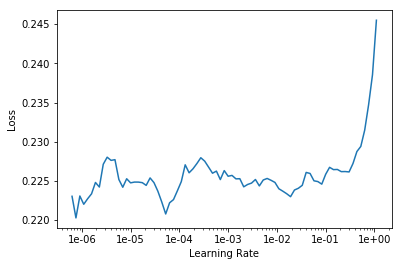

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(10, 3e-05)

epoch,train_loss,valid_loss,accuracy,roc,time
1,0.223552,0.229621,0.917200,0.865929,00:19
2,0.232613,0.229781,0.916800,0.865917,00:18
3,0.228706,0.228899,0.917100,0.866073,00:18
4,0.230862,0.229312,0.916800,0.866092,00:17


Epoch 5: early stopping


In [36]:
learn.save('v4.2 roc 866')

In [37]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [38]:
preds

tensor([[0.8408, 0.1592],
        [0.7543, 0.2457],
        [0.9330, 0.0670],
        ...,
        [0.9963, 0.0037],
        [0.9794, 0.0206],
        [0.8399, 0.1601]])

In [39]:
test_probs = np.array(preds[:, 1])

In [40]:
test_probs

array([0.159187, 0.245671, 0.067   , 0.13826 , ..., 0.022046, 0.003681, 0.020552, 0.16014 ], dtype=float32)

In [41]:
sub_df = pd.DataFrame({'ID_code': test_df["ID_code"], 'target': test_probs})

In [42]:
sub_df.head()

,ID_code,target
0,test_0,0.159187
1,test_1,0.245671
2,test_2,0.067000
3,test_3,0.138260
4,test_4,0.028517


In [43]:
sub_df.to_csv('submission2.csv', index=False)